# 1. Importing Libraries

In [1]:
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from mlxtend.plotting import plot_learning_curves
from mlxtend.data import mnist_data
from mlxtend.preprocessing import shuffle_arrays_unison

from imblearn.over_sampling import RandomOverSampler

from utils import createFeatures, listPeopleArticle

# 1. Importing Data

In [2]:
dataset = pd.read_csv("./dataset/listPerson.csv")
listDiagnosis = dataset["Diagnosis"].to_numpy()
listPerson = dataset[["velocityWeighted", "pressureWeighted", "CISP"]]


In [3]:
print(f'Paciêntes sem Parkinson = {dataset["Diagnosis"].value_counts()[0]}')
print(f'Paciêntes com Parkinson = {dataset["Diagnosis"].value_counts()[1]}')

Paciêntes sem Parkinson = 30
Paciêntes com Parkinson = 154


# 2. Applying Oversampling

In [35]:
ros = RandomOverSampler()
ros.fit(listPerson, listDiagnosis)
listPerson, listDiagnosis = ros.fit_resample(listPerson, listDiagnosis)

In [5]:
zero = 0
um = 0
for i in range(len(listDiagnosis)):
    if listDiagnosis[i]==0:
        zero += 1
    else:
        um += 1

print(f'Paciêntes sem Parkinson = {zero}')
print(f"Paciêntes com Parkinson = {um}")

Paciêntes sem Parkinson = 154
Paciêntes com Parkinson = 154


In [39]:
print(len(listPerson))

308


# 3. Process of Classifying

### 3.1. Applying Cross-Validation to Split the Data

In [6]:
n_splits = 10

In [7]:
kf = KFold(n_splits=n_splits,shuffle=True)

In [8]:
kf.get_n_splits()

10

### 3.2. Classification Algorithms Used:

- K-Nearest Neighbors
- Decision Tree
- Random Forest

In [9]:
knnc = KNeighborsClassifier()
cartc = DecisionTreeClassifier()

In [10]:
rfc = RandomForestClassifier()

# Number of trees in random forest
n_tree = np.arange(6, 16, 2)
# To measure the quality of a split
criterion = ['gini', 'entropy', 'log_loss']
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Method of selecting samples for training each tree
bootstrap = [False]
# Max depth of a tree
max_depth = np.arange(10, 30, 5)
# Create the random grid
param_grid = {'n_estimators': n_tree,
              'criterion': criterion,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_depth': max_depth}

rfc = GridSearchCV(estimator = rfc, param_grid = param_grid,cv = 3)

### 3.3. Training and Testing Phase

In [11]:
ss = StandardScaler()
TP_TN_FP_FN = np.zeros((3,4))

diagnosis = []
guesseddiagnosisknn = []
guesseddiagnosisdt = []
guesseddiagnosisrf = []

for train_index, test_index in kf.split(listPerson,y=listDiagnosis):
    
    x_train, x_test = listPerson.iloc[train_index], listPerson.iloc[test_index]
    y_train, y_test = listDiagnosis[train_index], listDiagnosis[test_index]
    
    x_train= ss.fit_transform(x_train)
    x_train = pd.DataFrame(x_train, columns = ['velocityWeighted','pressureWeighted','CISP'])
    x_test = ss.transform(x_test)
    x_test = pd.DataFrame(x_test, columns = ['velocityWeighted','pressureWeighted','CISP'])
    
    
    knnc_trained = knnc.fit(x_train, y_train)
    cartc_trained = cartc.fit(x_train, y_train)
    rfc_trained = rfc.fit(x_train, y_train)
    print(rfc.best_params_)
    
    
    
    modelsc = [knnc_trained, cartc_trained, rfc_trained]

    j = 0
    diagnosis.append(y_test[:])
    for model in modelsc:
        predict = model.predict(x_test)
        if model == modelsc[0]:
            guesseddiagnosisknn.append(model.predict(x_test))
        elif model == modelsc[1]:
            guesseddiagnosisdt.append(model.predict(x_test))
        else:
            guesseddiagnosisrf.append(model.predict(x_test))
        
        for i in range(y_test.shape[0]):
            if y_test[i] == 0 and predict[i] == 0:
                TP_TN_FP_FN[j][1] +=1
            elif y_test[i] == 1 and predict[i] == 1:
                TP_TN_FP_FN[j][0] +=1
            elif y_test[i] == 1 and predict[i] == 0:
                TP_TN_FP_FN[j][3] +=1
            elif y_test[i] == 0 and predict[i] == 1:
                TP_TN_FP_FN[j][2] +=1
        j+=1
    


{'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 12}
{'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 14}
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 10}
{'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 8}
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 6}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 12}
{'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 14}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 8}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 12}
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 

### 3.4. Computing Results

##### 3.4.1 Accuracy, Sensibility and Specificity Result

In [12]:
acc = np.empty(3)
sens = np.empty(3)
esp = np.empty(3)
for i in range(3):
    TP,TN,FP,FN = TP_TN_FP_FN[i]
    acc[i] = ((TP+TN)/(TP+TN+FN+FP)*100)
    sens[i] = ((TP)/(TP+FN)*100)
    esp[i] = ((TN)/(TN+FP)*100)

In [13]:
mod = ['KNN','DecisionTree','RandomForest']
nam = ['acurácia','sensibilidade','especificidade']
for i in range(3):
    print(f'{mod[i]} sua {nam[0]} é de {np.round(acc[i],2)}%')
for i in range(3):
    print(f'{mod[i]} sua {nam[1]} é de {np.round(sens[i],2)}%')
for i in range(3):
    print(f'{mod[i]} sua {nam[2]} é de {np.round(esp[i],2)}%')

KNN sua acurácia é de 87.01%
DecisionTree sua acurácia é de 96.1%
RandomForest sua acurácia é de 95.78%
KNN sua sensibilidade é de 77.27%
DecisionTree sua sensibilidade é de 92.21%
RandomForest sua sensibilidade é de 91.56%
KNN sua especificidade é de 96.75%
DecisionTree sua especificidade é de 100.0%
RandomForest sua especificidade é de 100.0%


##### 3.4.2. Confusion Matrix Result

##### K-Nearest Neighbors

In [14]:
cm_knn = [[0,0],[0,0]]
for i in range(len(diagnosis)):
    cm_knn += confusion_matrix(diagnosis[i],guesseddiagnosisknn[i])

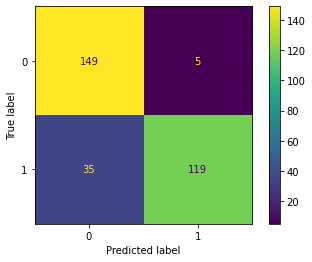

In [15]:
disp_knn = ConfusionMatrixDisplay(cm_knn)
disp_knn.plot()
plt.show()

##### Decision Tree

In [16]:
cm_dt = [[0,0],[0,0]]
for i in range(len(diagnosis)):
    cm_dt += confusion_matrix(diagnosis[i],guesseddiagnosisdt[i])

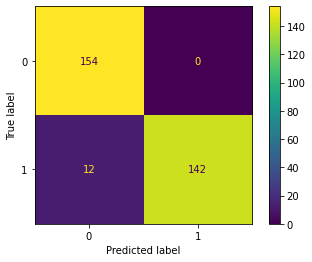

In [17]:
disp_dt = ConfusionMatrixDisplay(cm_dt)
disp_dt.plot()
plt.show()

##### Random Forest

In [18]:
cm_rf = [[0,0],[0,0]]
for i in range(len(diagnosis)):
    cm_rf += confusion_matrix(diagnosis[i],guesseddiagnosisrf[i])

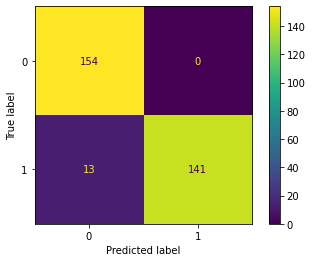

In [19]:
disp_rf = ConfusionMatrixDisplay(cm_rf)
disp_rf.plot()
plt.show()

##### 3.4.3. Learning Curve Result

In [20]:
#KNN
kn_train_sizes, kn_train_scores, kn_test_scores = learning_curve(KNeighborsClassifier(), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50), verbose=1)

#DecisionTree
dt_train_sizes, dt_train_scores, dt_test_scores = learning_curve(DecisionTreeClassifier(), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50), verbose=1)

#RandomForest
rf_train_sizes, rf_train_scores, rf_test_scores = learning_curve(RandomForestClassifier(), x_train, y_train, cv = 10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1, 50), verbose=1)


[learning_curve] Training set sizes: [  2   7  12  17  22  27  32  37  42  47  53  58  63  68  73  78  83  88
  93  98 103 108 113 118 123 128 133 138 143 148 154 159 164 169 174 179
 184 189 194 199 204 209 214 219 224 229 234 239 244 250]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [  2   7  12  17  22  27  32  37  42  47  53  58  63  68  73  78  83  88
  93  98 103 108 113 118 123 128 133 138 143 148 154 159 164 169 174 179
 184 189 194 199 204 209 214 219 224 229 234 239 244 250]


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[learning_curve] Training set sizes: [  2   7  12  17  22  27  32  37  42  47  53  58  63  68  73  78  83  88
  93  98 103 108 113 118 123 128 133 138 143 148 154 159 164 169 174 179
 184 189 194 199 204 209 214 219 224 229 234 239 244 250]


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.2s finished


In [21]:
#KNN
kn_train_mean = np.mean(kn_train_scores, axis=1)
kn_train_mean

kn_train_std = np.std(kn_train_scores, axis=1)
kn_train_std

kn_test_mean = np.mean(kn_test_scores, axis=1)
kn_test_mean

kn_test_std = np.std(kn_test_scores, axis=1)
kn_test_std

#DecisionTree
dt_train_mean = np.mean(dt_train_scores, axis=1)
dt_train_mean

dt_train_std = np.std(dt_train_scores, axis=1)
dt_train_std

dt_test_mean = np.mean(dt_test_scores, axis=1)
dt_test_mean

dt_test_std = np.std(dt_test_scores, axis=1)
dt_test_std

#RandomForest
rf_train_mean = np.mean(rf_train_scores, axis=1)
rf_train_mean

rf_train_std = np.std(rf_train_scores, axis=1)
rf_train_std

rf_test_mean = np.mean(rf_test_scores, axis=1)
rf_test_mean

rf_test_std = np.std(rf_test_scores, axis=1)
rf_test_std


array([0.0223263 , 0.0223263 , 0.0223263 , 0.11828237, 0.09543859,
       0.1030515 , 0.13521657, 0.1442408 , 0.13347478, 0.08699682,
       0.07815983, 0.0816279 , 0.11173616, 0.11051617, 0.14977003,
       0.16110459, 0.16544383, 0.18374173, 0.17835481, 0.17371754,
       0.17810167, 0.18374173, 0.19800156, 0.18441284, 0.1960691 ,
       0.18976222, 0.1956478 , 0.15064947, 0.11850471, 0.08571429,
       0.07824608, 0.06961996, 0.06071429, 0.0530931 , 0.05345225,
       0.04300569, 0.04857668, 0.04587583, 0.04300569, 0.04844521,
       0.05345225, 0.03970039, 0.04844521, 0.04587583, 0.05113508,
       0.04844521, 0.04285714, 0.0510102 , 0.0510102 , 0.03846546])

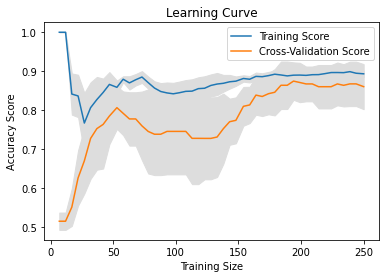

In [22]:
#KNN
plt.plot(kn_train_sizes, kn_train_mean, label='Training Score')
plt.plot(kn_train_sizes, kn_test_mean, label='Cross-Validation Score')

plt.fill_between(kn_train_sizes, kn_train_mean-kn_train_std, kn_train_mean+kn_train_std, color='#DDDDDD')
plt.fill_between(kn_train_sizes, kn_test_mean-kn_test_std, kn_test_mean+kn_test_std, color='#DDDDDD')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc = 'best')


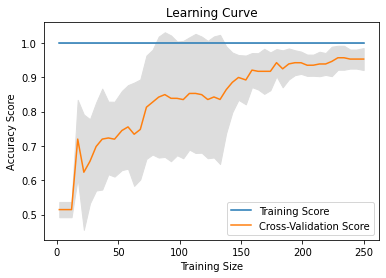

In [23]:
#DecisionTree
plt.plot(dt_train_sizes, dt_train_mean, label='Training Score')
plt.plot(dt_train_sizes, dt_test_mean, label='Cross-Validation Score')

plt.fill_between(dt_train_sizes, dt_train_mean-dt_train_std, dt_train_mean+dt_train_std, color='#DDDDDD')
plt.fill_between(dt_train_sizes, dt_test_mean-dt_test_std, dt_test_mean+dt_test_std, color='#DDDDDD')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc = 'best')


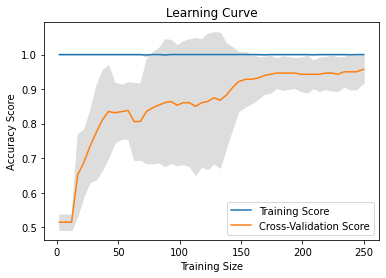

In [24]:
#RandomForest
plt.plot(rf_train_sizes, rf_train_mean, label='Training Score')
plt.plot(rf_train_sizes, rf_test_mean, label='Cross-Validation Score')

plt.fill_between(rf_train_sizes, rf_train_mean-rf_train_std, rf_train_mean+rf_train_std, color='#DDDDDD')
plt.fill_between(rf_train_sizes, rf_test_mean-rf_test_std, rf_test_mean+rf_test_std, color='#DDDDDD')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.legend(loc = 'best')

#### Shuffle Array

In [48]:
x, y = shuffle_arrays_unison(arrays=[listPerson.to_numpy(), listDiagnosis])

limit = int(((n_splits-1)/n_splits)*listPerson.shape[0])

X_train, X_test = x[:limit], x[limit:]
y_train, y_test = y[:limit], y[limit:]

X_train= ss.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = ['velocityWeighted','pressureWeighted','CISP'])
X_test = ss.transform(X_test)
X_test = pd.DataFrame(X_test, columns = ['velocityWeighted','pressureWeighted','CISP'])

#### KNN

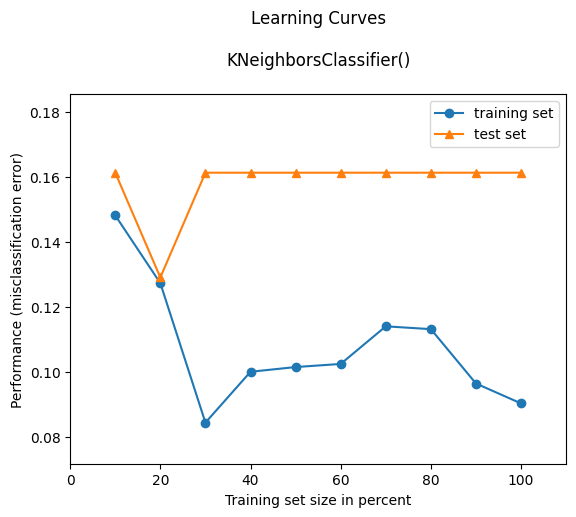

In [49]:
plot_learning_curves(X_train, y_train, X_test, y_test, knnc)
plt.show()

#### DecisionTree

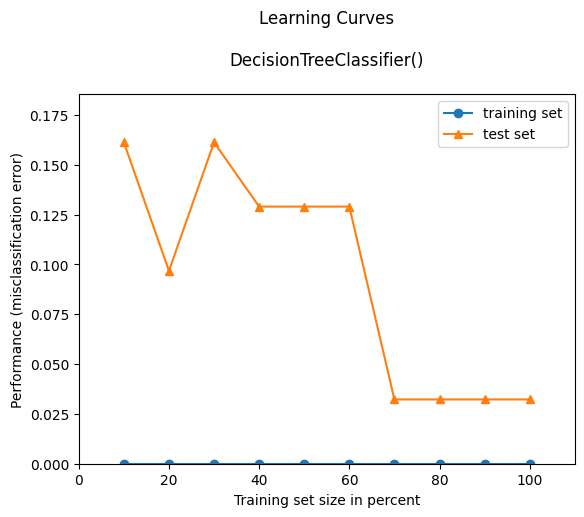

In [50]:
plot_learning_curves(X_train, y_train, X_test, y_test, cartc)
plt.show()

#### RandomForest

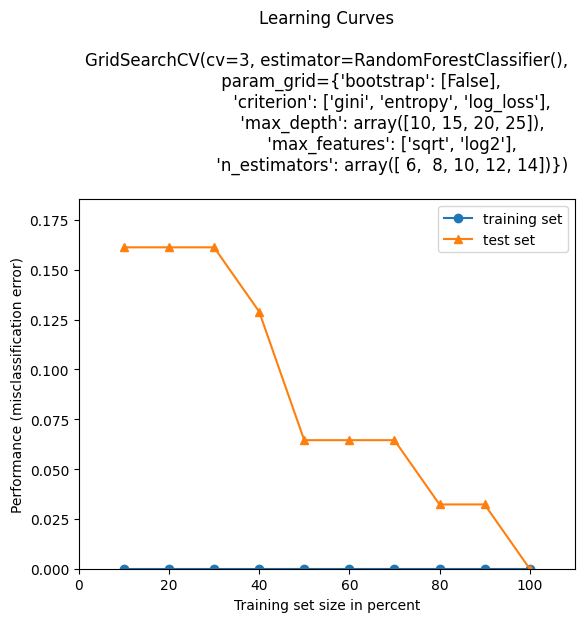

In [51]:
plot_learning_curves(X_train, y_train, X_test, y_test, rfc)
plt.show()